In [3]:
import pandas as pd
import numpy as np

# === 1. Carregar ===
pairs_df = pd.read_csv("pairs_df.csv")
compounds_df = pd.read_csv("compounds.csv")

# === 2. Normalizar nomes das colunas ===
pairs_df.columns = pairs_df.columns.str.strip().str.lower()
compounds_df.columns = compounds_df.columns.str.strip().str.lower()

# === 3. Identificar colunas de ID e SMILES ===
mol_id_col = "id" if "id" in compounds_df.columns else compounds_df.columns[0]
smiles_col = "smiles" if "smiles" in compounds_df.columns else compounds_df.columns[1]

# === 4. Add smiles ===
merged = pairs_df.merge(compounds_df[[mol_id_col, smiles_col]], left_on="mol1", right_on=mol_id_col)
merged = merged.merge(compounds_df[[mol_id_col, smiles_col]], left_on="mol2", right_on=mol_id_col, suffixes=("_mol1", "_mol2"))

# ✅ FILTRAR separation != -1
merged = merged[merged["separation"] != -1]

# === 5. Manter e ordenar pela coluna separation ===
merged = merged[["mol1", "smiles_mol1", "mol2", "smiles_mol2", "separation"]]

# Extract unique compounds that have corresponding entries in both 'mol1' and 'mol2' columns
unique_compounds_mol1 = merged["mol1"].unique()
unique_compounds_mol2 = merged["mol2"].unique()

# Find the intersection of unique compounds in both columns
valid_compounds = np.intersect1d(unique_compounds_mol1, unique_compounds_mol2)

# Extract existing pairs
existing_pairs = set(zip(merged["mol1"], merged["mol2"]))

# Generate random pairs of compounds that are not already in the dataset
random_pairs = []
while len(random_pairs) < 600:  # Let's generate 3 random pairs as an example
    mol1, mol2 = np.random.choice(valid_compounds, size=2, replace=False)
    if (mol1, mol2) not in existing_pairs:
        random_pairs.append((mol1, mol2))
        existing_pairs.add((mol1, mol2))

merged = merged.sort_values(by="separation").reset_index(drop=True)

# Create new rows for the random pairs
new_rows = [
    {
        "mol1": pair[0],
        "smiles_mol1": merged.loc[merged["mol1"] == pair[0], "smiles_mol1"].iloc[0],
        "mol2": pair[1],
        "smiles_mol2": merged.loc[merged["mol2"] == pair[1], "smiles_mol2"].iloc[0],
        "separation": "random pairs"
    }
    for pair in random_pairs
]

# Add the new rows to the DataFrame
merged = pd.concat([merged, pd.DataFrame(new_rows)], ignore_index=True)

# === 6. Exportar ===
merged.to_csv("merged_pairs_with_smiles.csv", index=False)

print("✅ Dataset criado: 'merged_pairs_with_smiles.csv'")



✅ Dataset criado: 'merged_pairs_with_smiles.csv'


Ciclo for para ir buscar os 2 smiles ao dataset:

In [4]:
import pandas as pd
import numpy as np
from rdkit.Chem import MolFromSmiles
from deepmol.compound_featurization import NPClassifierFP, BiosynfoniKeys, NeuralNPFP, MHFP, MorganFingerprint
from deepmol.compound_featurization import LLM
from tqdm import tqdm
from transformers import BertConfig, BertModel, ModernBertModel, ModernBertConfig 
from deepmol.tokenizers import NPBERTTokenizer
import os



# === 1. Carregar o dataset ===
df = pd.read_csv("merged_pairs_with_smiles.csv")

# === 2. Lista de featurizadores ===
featurizers = {
    "NPClassifierFP": NPClassifierFP(),
    "Biosynfoni": BiosynfoniKeys(),
    "NP_AUX": NeuralNPFP(),
    "MHFP": MHFP(),
    "MorganFP": MorganFingerprint(),
    "NPBERT": LLM(model_path="../NPBERT", model=BertModel, config_class=BertConfig,
                          tokenizer=NPBERTTokenizer(vocab_file=os.path.join("../NPBERT", "vocab.txt")), device="cuda:1"),
    "ModernBERT": LLM(model_path="../ModernBERT", model=ModernBertModel, config_class=ModernBertConfig, device="cuda:1")
}

# === 3. Função de similaridade do cosseno ===
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 0
    return dot_product / norm_product

# === 4. Aplicar para cada featurizador ===
for name, featurizer in featurizers.items():
    print(f"🔄 A calcular similaridade com: {name}")
    similarities = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Calculando similaridades para {name}"):
        smile1 = row["smiles_mol1"]
        smile2 = row["smiles_mol2"]

        if name in ["NPClassifierFP", "Biosynfoni", "NP_AUX", "MHFP", "MorganFP"]:
            mol1 = MolFromSmiles(smile1)
            mol2 = MolFromSmiles(smile2)

            if mol1 and mol2:
                try:
                    fp1 = featurizer._featurize(mol1)
                    fp2 = featurizer._featurize(mol2)
                    sim = cosine_similarity(fp1, fp2)
                except Exception as e:
                    sim = 0
            else:
                sim = 0

        else:
            try:
                fp1 = featurizer._featurize(smile1)
                fp2 = featurizer._featurize(smile2)
                sim = cosine_similarity(fp1, fp2)
            except Exception as e:
                sim = 0

        similarities.append(sim)

    df[name] = similarities

# === 5. Guardar resultado final ===
df.to_csv("merged_pairs_with_all_fps_cosine.csv", index=False)
print("✅ Todas as similaridades foram calculadas com sucesso.")


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/deepmol/compound_featurization/__init__.py:20: UserWarning: Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)
  warnings.warn("Mol2Vec not available. Please install it to use it. "
Some weights of BertModel were not initialized from the model checkpoint at ../NPBERT/model.pt and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 A calcular similaridade com: NPClassifierFP


Calculando similaridades para NPClassifierFP: 100%|██████████| 4297/4297 [00:09<00:00, 477.35it/s]


🔄 A calcular similaridade com: Biosynfoni


Calculando similaridades para Biosynfoni: 100%|██████████| 4297/4297 [00:07<00:00, 601.71it/s]


🔄 A calcular similaridade com: NP_AUX


Calculando similaridades para NP_AUX:   0%|          | 0/4297 [00:00<?, ?it/s]/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/deepmol/compound_featurization/neural_npfp_generator.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  fp = torch.tensor([fp], dtype=torch.float)
Calculando similaridades para NP_AUX: 100%|██████████| 4297/4297 [00:28<00:00, 153.04it/s]


🔄 A calcular similaridade com: MHFP


Calculando similaridades para MHFP:   0%|          | 8/4297 [00:00<00:56, 75.55it/s]/home/jcapela/.local/share/mamba/envs/np_benchmark/lib/python3.10/site-packages/deepmol/compound_featurization/_mhfp.py:305: UserWarning: The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.
  warnings.warn(
Calculando similaridades para MHFP: 100%|██████████| 4297/4297 [01:02<00:00, 68.96it/s] 


🔄 A calcular similaridade com: MorganFP


Calculando similaridades para MorganFP: 100%|██████████| 4297/4297 [00:09<00:00, 466.86it/s]


🔄 A calcular similaridade com: NPBERT


Calculando similaridades para NPBERT: 100%|██████████| 4297/4297 [00:48<00:00, 88.51it/s] 


🔄 A calcular similaridade com: ModernBERT


Calculando similaridades para ModernBERT: 100%|██████████| 4297/4297 [05:09<00:00, 13.88it/s]

✅ Todas as similaridades foram calculadas com sucesso.


Dar clean ao dataset
remove proton, water e o top 1% de frequencia

In [5]:
import pandas as pd

# === 1. Carregar o dataset ===
df = pd.read_csv("merged_pairs_with_all_fps_cosine.csv")

# === 2. Remover WATER e PROTON ===
df = df[~df["mol1"].isin(["WATER", "PROTON"]) & ~df["mol2"].isin(["WATER", "PROTON"])]

# === 3. Contar frequência total de cada molécula ===
mol_counts = pd.concat([df["mol1"], df["mol2"]]).value_counts()

# === 4. Determinar moléculas muito repetidas (top 1%) ===
threshold = mol_counts.quantile(0.99)
frequent_mols = mol_counts[mol_counts > threshold].index

# === 5. Remover pares com moléculas muito frequentes ===
df = df[~df["mol1"].isin(frequent_mols) & ~df["mol2"].isin(frequent_mols)]

# === 6. Guardar dataset filtrado ===
df.to_csv("filtered_pairs_removed_water_proton_repetidos.csv", index=False)

print("✅ Ficheiro salvo como 'filtered_pairs_removed_water_proton_repetidos.csv'")


✅ Ficheiro salvo como 'filtered_pairs_removed_water_proton_repetidos.csv'


Gráfico

Plotting separation: 1, n=609
Plotting separation: 2, n=503
Plotting separation: 3, n=436
Plotting separation: 4, n=367
Plotting separation: 5, n=294
Plotting separation: 6, n=216
Plotting separation: random pairs, n=587


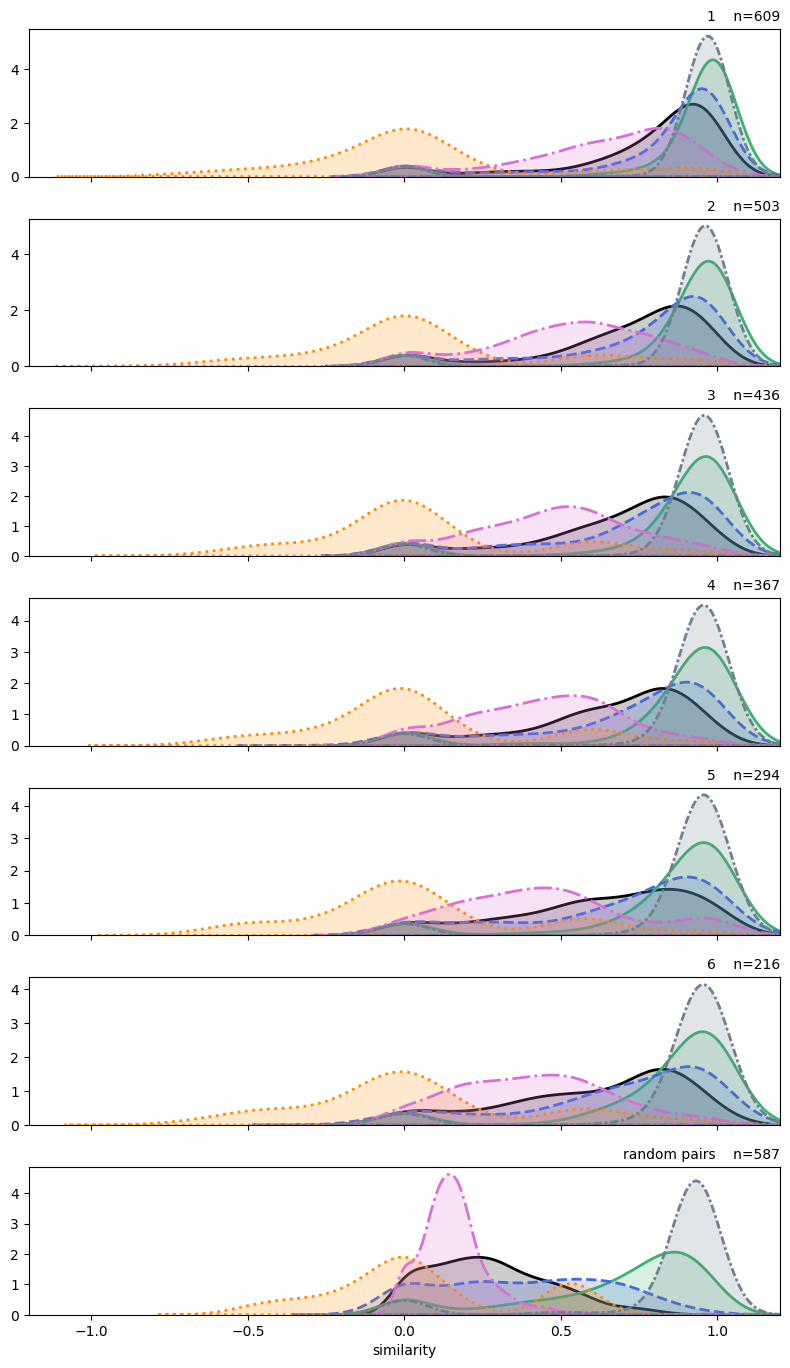

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("filtered_pairs_removed_water_proton_repetidos.csv")

# Define fingerprints to use
fps_all = ["NPClassifierFP", "Biosynfoni", "NP_AUX", "MHFP", "MorganFP", "NPBERT"]
fps = [fp for fp in fps_all if fp in df.columns]

# Define colors and linestyles
colors = {
    "NPClassifierFP": "black",
    "Biosynfoni": "mediumseagreen",
    "NP_AUX": "royalblue",
    "MHFP": "darkorange",
    "MorganFP": "orchid",
    "NPBERT": "slategray",
    # "ModernBERT": "darkviolet"
}

linestyles = {
    "NPClassifierFP": "-",
    "Biosynfoni": "-",
    "NP_AUX": "--",
    "MHFP": ":",
    "MorganFP": "-.",
    "NPBERT": (0, (3, 1, 1, 1)),
    # "ModernBERT": (0, (1, 1))
}

# Convert columns to numeric
for fp in fps:
    df[fp] = pd.to_numeric(df[fp], errors="coerce")

# Create the main plot
fig, axes = plt.subplots(7, 1, figsize=(8, 14), sharex=True)
for i, sep in enumerate([1, 2, 3, 4, 5, 6, "random pairs"]):
    ax = axes[i]
    subset = df[df["separation"] == str(sep)]
    print(f"Plotting separation: {sep}, n={len(subset)}")
    for fp in fps:
        if fp in subset.columns:
            sns.kdeplot(
                data=subset[fp].dropna(),
                ax=ax,
                label=fp if i == 0 else "",
                linewidth=2,
                linestyle=linestyles[fp],
                color=colors[fp],
                fill=True,
                alpha=0.2
            )
    ax.set_title(f"{sep}    n={len(subset)}", loc='right', fontsize=10)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylabel("")
    if i < 6:
        ax.set_xlabel("")
axes[-1].set_xlabel("similarity")

plt.tight_layout()
plt.subplots_adjust(top=0.96)

# Save the main plot
plt.savefig("fingerprint_similarity_distributions.png", dpi=300)
plt.show()
plt.close()

# Create a separate figure for the legend
fig_legend = plt.figure(figsize=(6, 2))
legend_handles = [
    plt.Line2D([0], [0], color=colors[fp], linestyle=linestyles[fp], linewidth=2)
    for fp in fps
]
fig_legend.legend(legend_handles, fps, title="NP representation", loc="center", ncol=len(fps))
fig_legend.savefig("legend.png", bbox_inches='tight', dpi=300)
plt.close(fig_legend)
